In [1]:
import pandas as pd
import numpy as np
import json
import os
import json
import wandb
import seaborn as sns
%matplotlib notebook

# Instance Model Results

In [2]:
model_dir = f"{os.environ['MINERVA_HOME']}/models/minerva_instance_models"

instance_model_res = {}
for split in ["val", "test"]:
    with open(f"{model_dir}/{split}_results.json") as f:
        instance_model_res[split] = json.load(f)
df = pd.DataFrame.from_dict(instance_model_res)

for row in df.itertuples():
    print(f"{row.Index.replace('eval_', '').capitalize()} & {row.val:.2} & {row.test:.2} \\\\")

Epoch & 5.5e+01 & 5.5e+01 \\
Accuracy & 0.85 & 0.82 \\
F1 & 0.86 & 0.82 \\
Loss & 1.5 & 1.9 \\
Positive_f1 & 0.65 & 0.6 \\
Precision & 0.89 & 0.84 \\
Recall & 0.85 & 0.82 \\
Runtime & 0.42 & 0.59 \\
Samples_per_second & 5.9e+02 & 4.7e+02 \\
Steps_per_second & 4.7 & 5.1 \\


# Baselines

In [3]:
baseline_dir = f"{os.environ['MINERVA_HOME']}/models/baselines"
baselines = {}
for file in os.listdir(baseline_dir):
    baseline_name = file.replace(".json", "")
    with open(f"{baseline_dir}/{file}") as f:
        baselines[baseline_name] = json.load(f)


In [4]:
baselines.keys()

dict_keys(['mil-i-0.6000000000000001_results', 'mil-i-0.1_results', 'mil-i-0.2_results', 'mil-i-0.30000000000000004_results', 'ngram_results', 'mil-i-0.9_results', 'mil-i-0.0_results', 'mil-i-0.5_results', 'mil-i-0.8_results', 'random_results', 'mil-i-0.7000000000000001_results', 'mil-i-0.4_results', 'country_random_results'])

# MIL Sweep

Load training experiments from Wandb API

In [9]:
api = wandb.Api()

# Project is specified by <entity/project-name>
runs = api.runs("aadelucia/Minerva", filters = {"group": "MIL-Min10-v2"})

summary_list, config_list, name_list = [], [], []
data = []
for run in runs: 
    row = {}
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    row.update({k:v for k,v in run.summary._json_dict.items()})
    
    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    row.update({k: v for k,v in run.config.items() if not k.startswith('_')})
    
    # .name is the human-readable name of the run.
    row["name"] = run.name
    
    # Add 
    data.append(row)

runs_df = pd.DataFrame(data)

How does key instance ratio effect the performance?

<IPython.core.display.Javascript object>


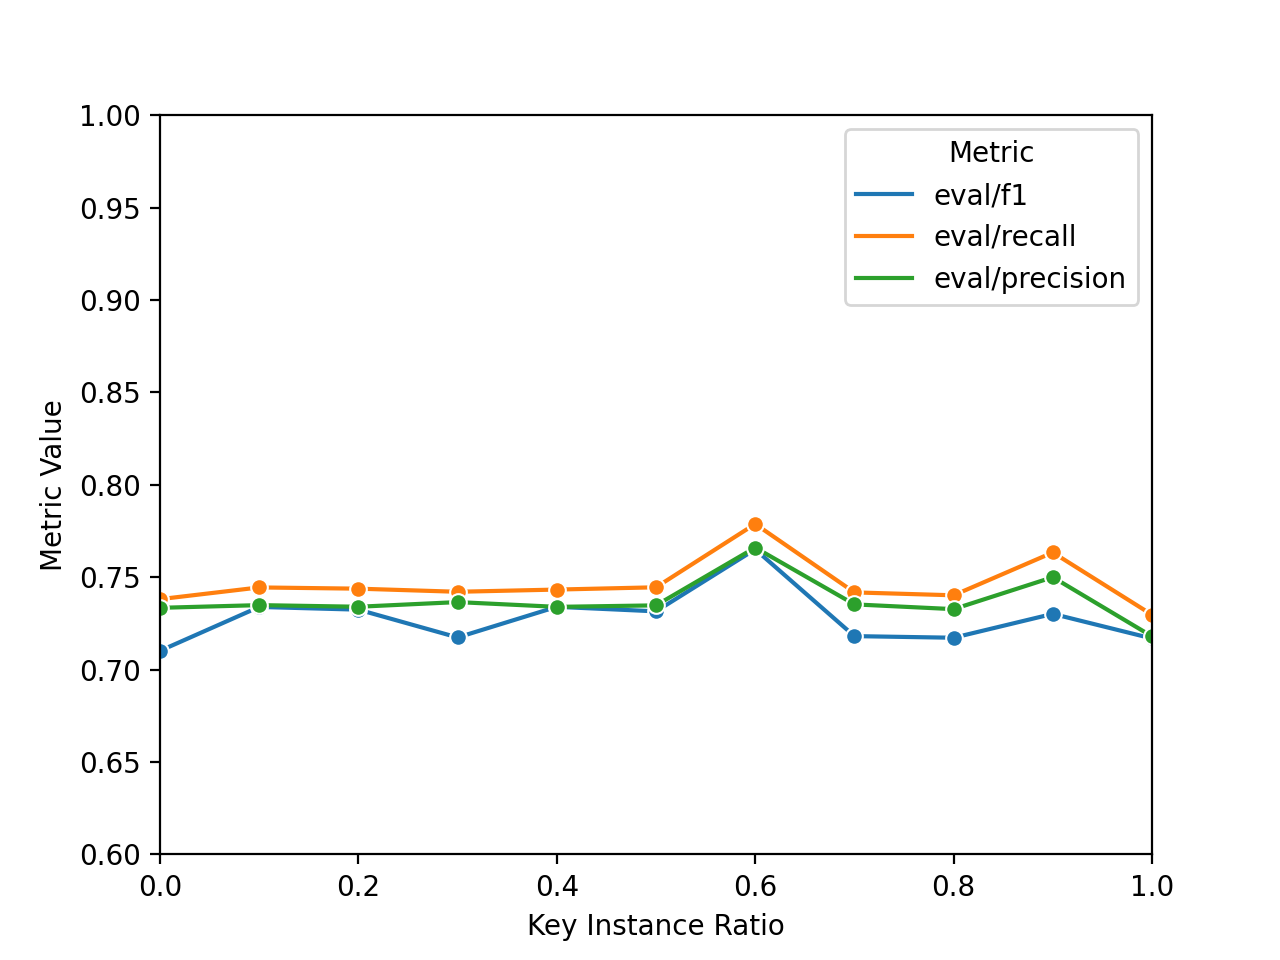

Text(0, 0.5, 'Metric Value')

In [10]:
d = pd.melt(
    runs_df, 
    id_vars=["key_instance_ratio"], 
    value_vars=["eval/f1", "eval/recall", "eval/precision"],
    var_name="Metric",
    value_name="Value"
)

g = sns.lineplot(d, x="key_instance_ratio", y="Value", hue="Metric", marker="o")
g.set(ylim=(0.6, 1), xlim=(0, 1))
g.set_xlabel("Key Instance Ratio")
g.set_ylabel("Metric Value")


Table version of the same results. Include

- All baselines
- F1, precision, and recall
- Best MIL run
- MIL max run (i.e, key instance ratio of 0)


In [ ]:
out = ""
summary = pd.concat([
    runs_df[runs_df.key_instance_ratio==0],
    runs_df.sort_values(by="eval/f1", ascending=False).iloc[0].to_frame().transpose()
])
for idx, row in summary.iterrows():
    out += f"MIL (k={row['key_instance_ratio']}) & {row['eval/f1']:.2} & {row['eval/precision']:.2} & {row['eval/recall']:.2} \\\\\n"

for b_name, res in baselines.items():
    b_name = " ".join(b_name.split("_"))
    out += f"{b_name.capitalize()} & {res['eval']['f1']:.2} & {res['eval']['precision']:.2} & {res['eval']['recall']:.2} \\\\\n"

print(out)



How many instances at each key instance ratio? Only need for training set.

In [ ]:
data_dir = f"{os.environ['MINERVA_HOME']}/data/premade_mil/minimum_10"
df = pd.read_json(f"{data_dir}/train.jsonl", lines=True)

In [ ]:
df

In [ ]:
instances_at_k = []
ratios = np.arange(0.0, 1.1, step=0.1)
for k in ratios:
    raw_values = df.num_instances.map(lambda x: max(int(np.floor(x * k)), 1))
    instances_at_k.append([
        k,
        np.mean(raw_values),
        np.std(raw_values),
        np.median(raw_values)
    ])
instances_at_k = pd.DataFrame(instances_at_k, columns=["k", "avg", "std", "med"])

In [ ]:
instances_at_k

In [ ]:
# Colors from https://seaborn.pydata.org/tutorial/color_palettes.html

In [ ]:
g2 = sns.lineplot(instances_at_k, x="k", y="avg", marker="o", label="Actual", color="#1f77b4")
g2.fill_between(
    instances_at_k["k"], 
    instances_at_k["avg"] - instances_at_k["std"],
    instances_at_k["avg"] + instances_at_k["std"],
    color="#1f77b4", alpha=0.2
)

# Add expected number of instances
g2.plot(ratios, [r*1000 for r in ratios], label="Expected", linestyle="--", marker="o", color="#ff7f0e")

# Format
g2.set(ylim=(0, 1000), xlim=(0, 1))
g2.set_xlabel("Key Instance Ratio")
g2.set_ylabel("Number of Instances")
g2.legend()
